文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型!

這次課程分為7個部分：
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. lexicon-based 的主題模型
4. LDA 主題模型 
5. 視覺化主題模型 
6. GuidedLDA
7. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

In [154]:
udn = pd.read_csv("raw_data/udn_news.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,MLB／曾說「不是朋友」成真 大谷翔平解除追蹤水原一平,2024/3/21 9:56,運動,https://udn.com/news/story/11247/7845714,曾經是形影不離的戰友，大谷翔平與水原一平如今因金錢關係成為陌生人，大谷翔平的個人社群也解除對...,UDN
1,2,MLB／水原一平涉賭被解僱 日本網友震驚「巨大背叛」,2024/3/21 10:28,運動,https://udn.com/news/story/11247/7845808,日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美元非法簽賭，已遭洛杉磯道奇解雇。大谷轉...,UDN
2,3,MLB／偷大谷翔平的錢還賭債！水原一平IG被球迷灌爆：你搞屁啊,2024/3/21 10:36,運動,https://udn.com/news/story/11247/7845856,美國職棒大聯盟（MLB）球星大谷翔平的隨行翻譯水原一平，因涉嫌竊取大谷至少450萬美元進行非...,UDN


In [155]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(10)

,content,artUrl,artCatagory,artDate
0,曾經是形影不離的戰友大谷翔平與水原一平如今因金錢關係成為陌生人大谷翔平的個人社群也解除對水原...,https://udn.com/news/story/11247/7845714,運動,2024/3/21 9:56
1,日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美元非法簽賭已遭洛杉磯道奇解雇大谷轉戰美...,https://udn.com/news/story/11247/7845808,運動,2024/3/21 10:28
2,美國職棒大聯盟球星大谷翔平的隨行翻譯水原一平因涉嫌竊取大谷至少萬美元進行非法賭博遭到道奇隊開...,https://udn.com/news/story/11247/7845856,運動,2024/3/21 10:36
3,道奇教士隊在南韓首爾進行新球季第場比賽前大谷翔平的翻譯水原一平遭球團開除一位美職賽事資深球評...,https://udn.com/news/story/11247/7845919,運動,2024/3/21 10:56
4,美國職棒大聯盟明星大谷翔平的翻譯水原一平傳出涉賭遭球隊解僱水原美國時間日接受採訪說大谷替他還...,https://udn.com/news/story/11247/7846177,運動,2024/3/21 12:13
5,美國職業棒球大聯盟球員大谷翔平的翻譯水原一平嗜賭釀禍醫師葉啓斌今天表示成癮者戒除過程很痛苦會...,https://udn.com/news/story/11247/7846281,運動,2024/3/21 12:40
6,大谷翔平的貼身翻譯水原一平陷入簽賭偷竊事件日本各家媒體一大早就開始大幅報導這起醜聞迅速傳遍全...,https://udn.com/news/story/11247/7846330,運動,2024/3/21 12:49
7,美國職棒大聯盟球星大谷翔平的隨行翻譯水原一平因涉嫌竊取大谷至少萬美元進行非法賭博遭到道奇隊開...,https://udn.com/news/story/11247/7846596,運動,2024/3/21 14:06
8,美國職棒洛杉磯道奇隊日籍球星大谷翔平今日已從南韓首爾市內的球隊宿舍出發前往高尺巨蛋與教士隊打...,https://udn.com/news/story/11247/7846694,運動,2024/3/21 14:35
9,二刀流巨星大谷翔平的御用翻譯員水原一平今日驚傳因涉嫌非法簽賭遭開除且他因竊取大谷資金罪名連帶...,https://udn.com/news/story/11247/7846731,運動,2024/3/21 15:19


In [156]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /Users/wuanjie/Desktop/NLP/SocialAnalysis_3rd/week10/dict/dict.txt ...
2024-05-05 16:33:09,381 : DEBUG : Building prefix dict from /Users/wuanjie/Desktop/NLP/SocialAnalysis_3rd/week10/dict/dict.txt ...
Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u60c6c0577929ff4c4e5735bf8440f309.cache
2024-05-05 16:33:09,384 : DEBUG : Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u60c6c0577929ff4c4e5735bf8440f309.cache
Loading model cost 1.418 seconds.
2024-05-05 16:33:10,802 : DEBUG : Loading model cost 1.418 seconds.
Prefix dict has been built successfully.
2024-05-05 16:33:10,809 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,曾經是形影不離的戰友大谷翔平與水原一平如今因金錢關係成為陌生人大谷翔平的個人社群也解除對水原...,https://udn.com/news/story/11247/7845714,運動,2024/3/21 9:56,"[曾經, 形影不離, 戰友, 大谷翔平, 水原, 一平, 金錢, 關係, 成為, 陌生人, ..."
1,日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美元非法簽賭已遭洛杉磯道奇解雇大谷轉戰美...,https://udn.com/news/story/11247/7845808,運動,2024/3/21 10:28,"[日本, 棒球, 明星, 大谷翔平, 翻譯, 水原, 一平, 傳出, 涉嫌, 竊取, 數百,..."
2,美國職棒大聯盟球星大谷翔平的隨行翻譯水原一平因涉嫌竊取大谷至少萬美元進行非法賭博遭到道奇隊開...,https://udn.com/news/story/11247/7845856,運動,2024/3/21 10:36,"[美國, 職棒, 大聯盟, 球星, 大谷翔平, 隨行, 翻譯, 水原, 一平, 涉嫌, 竊取..."
3,道奇教士隊在南韓首爾進行新球季第場比賽前大谷翔平的翻譯水原一平遭球團開除一位美職賽事資深球評...,https://udn.com/news/story/11247/7845919,運動,2024/3/21 10:56,"[道奇, 教士隊, 南韓, 首爾, 進行, 新球季, 第場, 比賽, 大谷翔平, 翻譯, 水..."
4,美國職棒大聯盟明星大谷翔平的翻譯水原一平傳出涉賭遭球隊解僱水原美國時間日接受採訪說大谷替他還...,https://udn.com/news/story/11247/7846177,運動,2024/3/21 12:13,"[美國, 職棒, 大聯盟, 明星, 大谷翔平, 翻譯, 水原, 一平, 傳出, 涉賭, 球隊..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [157]:
udn['artCatagory'].unique()

array(['運動', '全球', '股市', '兩岸'], dtype=object)

In [158]:
## 定義主題
sport_cnt = udn.loc[udn['artCatagory'] == '運動',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['今天', '比賽', '大谷', '水原', '球員', '球隊', '表示', '今年', '大谷翔平', '投手', '先發',
       '去年', '台灣', '安打', '大聯盟', '聯盟', '選手', '表現', '大巨蛋', '球迷', '生涯', '一平',
       '希望', '成為', '熱身賽', '日本', '最後', '運動', '紀錄', '台北', '拿下', '領先', '機會', '教練',
       '賽事', '出賽', '記者', '目前', '籃板', '開幕戰', '世界', '道奇', '美國', '中職', '翻譯', '進行',
       '即時', '職棒', '本季', '主場', '悍將', '總教練', '冠軍', '高中', '面對', '樂天', '最終', '戰績',
       '賽季', '棒球', '時間', '數據', '大學', '敲出', '排名', '球場', '擊敗', '失分', '助攻', '昨天',
       '球團', '兄弟', '勇士', '中信', '籃球', '三分球', '取得', '對手', '中華', '富邦', '巨蛋', '開季',
       '狀況', '過去', '雄鷹', '攻下', '攝影', '擔任', '獲得', '提供', '隊友', '得分', '球星', '指出',
       '出現', '參加', '團隊', '開打', '賽程', '挑戰'],
      dtype='object', name='words')

In [159]:
stock_cnt = udn.loc[udn['artCatagory'] == '股市',:]['words'].explode().value_counts().head(200)
pprint(" ".join(stock_cnt.index))

('市場 今年 億元 投資 台股 成長 台灣 營收 表示 投資人 公司 指數 去年 持續 股息 股價 美國 表現 投信 預期 基金 獲利 目前 產品 產業 '
 '法人 需求 動能 相關 上漲 高息 指出 第季 半導體 股利 台積電 全球 債券 股票 科技 主要 營運 未來 降息 資金 配息 外資 風險 增加 純益 '
 '成分股 漲幅 上市 企業 規模 客戶 新高 現金 每股 帶動 發展 布局 伺服器 元大 超過 受惠 看好 年增 昨日 預估 近期 包括 價格 交易 股市 '
 '買超 維持 資產 掛牌 影響 下跌 可望 經濟 歷史 機會 鴻海 預計 提升 殖利率 提供 長期 金額 展望 成為 統一 建議 應用 方面 期貨 利率 '
 '晶片 智慧 族群 收益 透過 趨勢 證券 輝達 有望 公告 業務 政策 今日 配發 震盪 行情 認為 技術 金融 個股 今天 統計 價值 永續 相對 '
 '資本 服務 募集 聯準會 大陸 顯示 發行 群益 大盤 訂單 出現 中國 進行 持有 買進 持股 賣超 三大 日本 大幅 平均 中心 產能 供應鏈 盤中 '
 '策略 觀察 毛利率 美元 通膨 國際 淨值 盈餘 出貨 時間 公布 管理 強勁 合併 推出 商品 擴大 調整 資訊 穩定 終場 系統 合作 優於 操作 '
 '數據 美股 電子 業績 參與 申購 業者 投顧 庫存 推升 目標 進入 下半年 累計 董事會 臺灣 銀行 報酬 市值 分析 積極 董事長 開發 收盤 '
 '集團')


In [160]:
political_cnt = udn.loc[udn['artCatagory'] == '全球',:]['words'].explode().value_counts().head(200)
pprint(" ".join(political_cnt.index))

('美國 表示 中國 報導 以色列 日本 政府 公司 今天 國家 指出 俄羅斯 今年 去年 川普 烏克蘭 總統 美元 市場 認為 台灣 安全 拜登 經濟 '
 '發生 加薩 目前 包括 全球 英國 媒體 進行 組織 支持 行動 瑪斯 問題 國際 時間 影響 官員 顯示 戰爭 要求 攻擊 持續 政策 計畫 指數 '
 '人士 降息 造成 提供 巴勒斯坦 數據 地區 調查 關係 人員 衝突 宣布 聲明 企業 聯合國 合作 億美 利率 聯邦 使用 晶片 投資 預期 事件 '
 '正在 透過 工作 國會 成為 相關 民眾 通膨 出現 活動 一名 主要 增加 日圓 未來 希望 印度 政治 目標 技術 歐洲 更多 委員會 研究 當局 '
 '上漲 世界 導致 南韓 接受 生產 重要 提出 央行 俄國 過去 軍事 超過 大陸 報告 總理 輝達 情況 消息 需要 舉行 這項 無法 成長 澳洲 '
 '選舉 發布 發現 現在 法新社 公布 科技 德國 法國 電動車 菲律賓 產品 移民 平台 會議 社群 停火 機構 汽車 價格 死亡 智慧 至少 加薩走廊 '
 '普亭 歷史 強調 北韓 發展 大學 援助 歐盟 繼續 投資人 系統 決定 引發 需求 預計 面臨 飛彈 維持 故事 期間 措施 採取 中心 莫斯科 產業 '
 '告訴 代表 發言人 路透 戰火 路透社 聯準會 發表 討論 大選 進入 嚴重 風險 空襲 仇恨 伊朗 中央 能源 內容 百年 訪問 保護 不斷 記者 '
 '減少 銀行 蘋果 資金')


In [161]:
custom_topic_word = {
    "運動": [
        "球員", 
        "球隊", 
        "大谷翔平", 
        "投手",
        "先發",
        "安打", 
        "大聯盟", 
        "聯盟", 
        "選手", 
        "球迷", 
        "生涯", 
        "熱身賽", 
        "運動", 
        "教練",
        "賽事", 
        "開幕戰", 
        "道奇", 
        "中職",
        "職棒", 
        "主場", 
        "悍將", 
        "樂天", 
        "賽季", 
        "棒球",
        "職棒",
        "比賽",
        "賽事",
        "球員",
        "投手",
        "戰績",
        "球隊",
        "球迷",
        "選手",
        "春訓",
        "分組",
        "先發",
        "比分",
        "安打",
        "大谷",
        "冠軍",
        "籃球",
        "NBA",
        "勇士",
        "主場",
        "運動",
        "籃板", 
        "奧運",
        "三分球",
        "籃板",
        "助攻",
        "得分",
        "大三元",
        "球星",
    ],
    "股市": [
        "市場",
        "成長",
        "投資",
        "投信",
        "指數",
        "台股",
        "每股",
        "指數", 
        "營運",
        "股利",
        "獲利",
        "現金",
        "年增",
        "股價",
        "台積電",
        "半導體",
        "投資人",
        "法人",
        "降息", 
        "銀行",
        "上漲",
        "升息",
        "股息",
        "配發",
        "股票",
        "基金",
        "上市",
        "配息",
        "金融",
        "聯準會",
        "債券",
        "下跌",
        "漲幅",
    ],
    "產業": [
        "產業",
        "產品",
        "需求",
        "客戶",
        "董事會",
        "公司",
        "營收",
        "經濟",
        "庫存",
        "企業",
        "國際",
        "台積電",
        "業務",
        "盈餘",
        "風險",
        "服務",
        "資本",
        "機會",
        "集團",
        "電子",
        "半導體",
        "能源",
        "布局",
        "科技",
        "電動車",
        "智慧",
        "鴻海",
        "品牌",
        "網路",
    ],
    "兩岸": [
        "中國",
        "大陸",
        "兩岸",
        "習近平",
        "北京",
        "人民幣",
        "中共",
        "上海",
        "國務院",
        "李強",
        "華為",
        "政協",
        "兩會",
    ],
    "全球": [
        "美國", 
        "中國", 
        "以色列",
        "日本",
        "俄羅斯", 
        "川普", 
        "烏克蘭",
        "拜登", 
        "經濟", 
        "加薩", 
        "英國", 
        "國際", 
        "戰爭", 
        "攻擊", 
        "巴勒斯坦", 
        "衝突", 
        "聯邦", 
        "通膨", 
        "日圓", 
        "未來", 
        "希望", 
        "印度",
    ],
}

In [162]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [163]:
vocabularies

array(['NBA', '三分球', '上市', '上海', '上漲', '下跌', '中共', '中國', '中職', '主場',
       '人民幣', '以色列', '企業', '俄羅斯', '債券', '先發', '兩岸', '兩會', '公司', '冠軍',
       '分組', '加薩', '助攻', '勇士', '北京', '升息', '半導體', '印度', '台積電', '台股', '品牌',
       '國務院', '國際', '基金', '大三元', '大聯盟', '大谷', '大谷翔平', '大陸', '奧運', '安打',
       '客戶', '川普', '巴勒斯坦', '市場', '布局', '希望', '年增', '庫存', '得分', '悍將', '成長',
       '戰爭', '戰績', '投信', '投手', '投資', '投資人', '拜登', '指數', '攻擊', '政協', '教練',
       '日圓', '日本', '春訓', '智慧', '服務', '未來', '李強', '棒球', '業務', '樂天', '機會',
       '每股', '比分', '比賽', '法人', '漲幅', '烏克蘭', '熱身賽', '營收', '營運', '獲利', '現金',
       '球員', '球星', '球迷', '球隊', '生涯', '產品', '產業', '盈餘', '科技', '籃板', '籃球',
       '經濟', '網路', '美國', '習近平', '聯準會', '聯盟', '聯邦', '職棒', '股價', '股利', '股息',
       '股票', '能源', '英國', '華為', '董事會', '衝突', '資本', '賽事', '賽季', '通膨', '運動',
       '道奇', '選手', '配息', '配發', '金融', '銀行', '開幕戰', '降息', '集團', '電動車', '電子',
       '需求', '風險', '鴻海'], dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [164]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1375: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [165]:
udn_matrix.shape

(6458, 132)

In [167]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_運動,topic_股市,topic_產業,topic_兩岸,topic_全球
0,19,0,1,0,1
1,33,1,0,0,8
2,24,0,0,0,4
3,19,0,2,0,2
4,41,1,4,0,14
...,...,...,...,...,...
6453,0,0,0,7,0
6454,0,3,5,3,2
6455,0,0,3,1,1
6456,0,0,0,1,1


In [168]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_運動,topic_股市,topic_產業,topic_兩岸,topic_全球
0,0.904762,0.000000,0.047619,0.0,0.047619
1,0.785714,0.023810,0.000000,0.0,0.190476
2,0.857143,0.000000,0.000000,0.0,0.142857
3,0.826087,0.000000,0.086957,0.0,0.086957
4,0.683333,0.016667,0.066667,0.0,0.233333


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

**4.1 處理新聞**

In [169]:
docs = udn['words'].to_list()
docs[0]

['曾經',
 '形影不離',
 '戰友',
 '大谷翔平',
 '水原',
 '一平',
 '金錢',
 '關係',
 '成為',
 '陌生人',
 '大谷翔平',
 '社群',
 '解除',
 '水原',
 '關注',
 '季前',
 '一番',
 '朋友',
 '玩笑話',
 '成真',
 '大谷翔平',
 '貼身',
 '翻譯',
 '水原',
 '一平',
 '涉及',
 '非法',
 '運動',
 '博弈',
 '積欠',
 '美元',
 '債務',
 '對象',
 '莊家',
 '帳戶',
 '匯款',
 '名單',
 '出現',
 '大谷翔平',
 '名字',
 '水原',
 '大谷翔平',
 '律師',
 '指控',
 '盜竊',
 '道奇',
 '球團',
 '證實',
 '開除',
 '此人',
 '大谷翔平',
 '正在',
 '南韓',
 '參加',
 '道奇隊',
 '海外',
 '開幕戰',
 '發表',
 '評論',
 '看出',
 '解除',
 '水原',
 '追蹤',
 '水原',
 '的則',
 '追蹤',
 '大谷',
 '水原',
 '指控',
 '動用',
 '大谷翔平',
 '帳戶',
 '金錢',
 '償還',
 '賭債',
 '匯款',
 '時間',
 '去年',
 '今年',
 '大谷',
 '加盟',
 '道奇隊',
 '球迷',
 '水原',
 '業務',
 '關係',
 '朋友',
 '這番',
 '玩笑話',
 '逗得',
 '球迷',
 '開懷',
 '一語成讖',
 '水原',
 '涉賭',
 '風波',
 '現身',
 '大谷翔平',
 '不發',
 '一語',
 '快步',
 '離開',
 '飯店',
 '大谷',
 '翻譯',
 '艾爾頓',
 '怪人',
 '網友',
 '瘋傳',
 '袒胸',
 '露肚',
 '摔角',
 '背叛',
 '大谷',
 '背叛',
 '火腿',
 '日本人',
 '無法',
 '原諒',
 '水原',
 '一平',
 '大谷翔平',
 '爆有簽',
 '婚前',
 '協議書',
 '道奇',
 '日圓',
 '合約金',
 '梭哈']

In [170]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-05 16:44:32,251 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-05 16:44:34,470 : INFO : built Dictionary<76965 unique tokens: ['一平', '一番', '一語', '一語成讖', '不發']...> from 6458 documents (total 1286441 corpus positions)
2024-05-05 16:44:34,471 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<76965 unique tokens: ['一平', '一番', '一語', '一語成讖', '不發']...> from 6458 documents (total 1286441 corpus positions)", 'datetime': '2024-05-05T16:44:34.471491', 'gensim': '4.3.2', 'python': '3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.5-x86_64-i386-64bit', 'event': 'created'}
2024-05-05 16:44:34,645 : INFO : discarding 58132 tokens: [('一語成讖', 4), ('玩笑話', 4), ('逗得', 2), ('開懷', 2), ('不致於', 2), ('兩職', 1), ('右肘', 4), ('園田芳', 2), ('蠢蛋', 1), ('驚愕', 2)]...
2024-05-05 16:44:34,646 : INFO : keeping 18833 tokens which were in no less than 5 and no more than 6393 (=99.0%) documents
2024-05-05 16:44:34,749 : I

Dictionary<18833 unique tokens: ['一平', '一番', '一語', '不發', '今年']...>


In [171]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一平: 0
一番: 1
一語: 2
不發: 3
今年: 4
債務: 5
償還: 6
出現: 7
加盟: 8
動用: 9
匯款: 10
協議書: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [172]:
pprint(" ".join(udn['words'].iloc[600]))


('今年 中華 職棒 正式 迎接 回到 六隊 規模 鋼雄 鷹隊 元年 高雄 澄清湖 主場 開幕戰 重要 日子 中華 職棒 開打 當天 出賽 選手 職棒圈 '
 '打拚 雄鷹 團隊 當天 將由 總教練 洪一中 領軍 受邀 擔任 特別 嘉賓 職棒 開幕日 進行 兄弟 統一 味全 三商 兩場 比賽 總計 吸引 超過 '
 '萬名 觀眾 萬人 加人 正式 掀起 台灣 職棒 熱潮 參與 台鋼 雄鷹 建軍 貢獻 良多 教練 球探 職棒 開幕日 出賽 創隊 歷程 特別 日子 台鋼 '
 '雄鷹 球團 特別 開幕戰 邀請 齊聚 現場 致敬 接受 現場 球迷 掌聲 喝采 開幕戰 當天 球團 特別 設計 具一款 特殊 紀念 意義 雄鷹 紀念球 '
 '為首場 賽事 比賽用球 台鋼 雄鷹 一軍 總教練 洪一中 職棒 開幕戰 兄弟象隊 三棒 捕手 打數 安打 打點 三壘 安打 台鋼 雄鷹 二軍 總教練 '
 '林振賢 職棒 開幕日 三商虎隊 先發 六棒 中外野手 打數 安打 台鋼 雄鷹 球探 杜福明 職棒 開幕戰 統一獅隊 先發 投手 以局 失分 成為 中華 '
 '職棒史 勝利 投手 史上 台鋼 雄鷹 客座 捕手 教練 百亨 職棒 開幕戰 兄弟象隊 七棒 一壘手 打數 安打')


In [173]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(4, 1),
 (30, 1),
 (52, 2),
 (53, 1),
 (79, 6),
 (118, 2),
 (119, 2),
 (120, 1),
 (122, 1),
 (126, 2)]

In [174]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [175]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [176]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics= 10, # 生成幾個主題數
    random_state=2048, # 亂數
)

2024-05-05 16:44:48,152 : INFO : using symmetric alpha at 0.1
2024-05-05 16:44:48,165 : INFO : using symmetric eta at 0.1
2024-05-05 16:44:48,193 : INFO : using serial LDA version on this node
2024-05-05 16:44:48,249 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 6458 documents, updating model once every 2000 documents, evaluating perplexity every 6458 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 16:44:48,257 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 16:44:48,270 : INFO : PROGRESS: pass 0, at document #2000/6458
2024-05-05 16:44:50,513 : INFO : merging changes from 2000 documents into a model of 6458 documents
2024-05-05 16:44:50,529 : INFO : topic #0 (0.100): 0.011*"表示" + 0.006*"今天" + 0.006*"俄羅斯" + 0.004*"總統" + 0.004*"報導" + 0.004*"烏克蘭" + 0.004*"國家" + 0.003*"普亭" + 0.003*"日本" + 0.003*"去年"
2024-05-05 16:

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [177]:
ldamodel.print_topics()

2024-05-05 16:45:00,946 : INFO : topic #0 (0.100): 0.010*"表示" + 0.008*"公司" + 0.007*"中國" + 0.006*"大陸" + 0.005*"企業" + 0.005*"報導" + 0.005*"政策" + 0.004*"指出" + 0.004*"集團" + 0.004*"國家"
2024-05-05 16:45:00,952 : INFO : topic #1 (0.100): 0.019*"大陸" + 0.016*"晶片" + 0.010*"美國" + 0.008*"中國" + 0.008*"表示" + 0.007*"商務部" + 0.007*"公司" + 0.007*"股價" + 0.006*"輝達" + 0.006*"半導體"
2024-05-05 16:45:00,996 : INFO : topic #2 (0.100): 0.026*"中國" + 0.014*"大陸" + 0.012*"香港" + 0.011*"發展" + 0.010*"經濟" + 0.008*"美國" + 0.007*"表示" + 0.007*"企業" + 0.007*"市場" + 0.006*"蘋果"
2024-05-05 16:45:01,013 : INFO : topic #3 (0.100): 0.008*"漲幅" + 0.006*"今年" + 0.006*"表現" + 0.006*"族群" + 0.005*"投資人" + 0.005*"表示" + 0.005*"去年" + 0.005*"今天" + 0.005*"薪酬" + 0.004*"網友"
2024-05-05 16:45:01,036 : INFO : topic #4 (0.100): 0.010*"美國" + 0.007*"中國" + 0.007*"表示" + 0.006*"公司" + 0.005*"報導" + 0.004*"申請" + 0.004*"台灣" + 0.004*"指出" + 0.004*"半導體" + 0.004*"國際"
2024-05-05 16:45:01,047 : INFO : topic #5 (0.100): 0.029*"中國" + 0.020*"汽車" + 0.017*"小米" + 0.016*"人民幣"

[(0,
  '0.010*"表示" + 0.008*"公司" + 0.007*"中國" + 0.006*"大陸" + 0.005*"企業" + 0.005*"報導" + 0.005*"政策" + 0.004*"指出" + 0.004*"集團" + 0.004*"國家"'),
 (1,
  '0.019*"大陸" + 0.016*"晶片" + 0.010*"美國" + 0.008*"中國" + 0.008*"表示" + 0.007*"商務部" + 0.007*"公司" + 0.007*"股價" + 0.006*"輝達" + 0.006*"半導體"'),
 (2,
  '0.026*"中國" + 0.014*"大陸" + 0.012*"香港" + 0.011*"發展" + 0.010*"經濟" + 0.008*"美國" + 0.007*"表示" + 0.007*"企業" + 0.007*"市場" + 0.006*"蘋果"'),
 (3,
  '0.008*"漲幅" + 0.006*"今年" + 0.006*"表現" + 0.006*"族群" + 0.005*"投資人" + 0.005*"表示" + 0.005*"去年" + 0.005*"今天" + 0.005*"薪酬" + 0.004*"網友"'),
 (4,
  '0.010*"美國" + 0.007*"中國" + 0.007*"表示" + 0.006*"公司" + 0.005*"報導" + 0.004*"申請" + 0.004*"台灣" + 0.004*"指出" + 0.004*"半導體" + 0.004*"國際"'),
 (5,
  '0.029*"中國" + 0.020*"汽車" + 0.017*"小米" + 0.016*"人民幣" + 0.008*"表示" + 0.008*"報導" + 0.007*"公司" + 0.007*"上海" + 0.006*"大陸" + 0.005*"發布"'),
 (6,
  '0.008*"表示" + 0.008*"網友" + 0.007*"中國" + 0.006*"報導" + 0.004*"工作" + 0.004*"台灣" + 0.004*"認為" + 0.004*"新聞" + 0.004*"大陸" + 0.003*"香港"'),
 (7,
  '0.012*"黃金" + 0

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：

+ 主題0：圍繞中國與國際政策的變動，特別是對企業和集團的影響，以及國家政策的角色。
+ 主題1：專注於半導體產業，特別是中美在晶片及半導體市場的競爭，以及輝達公司和其他企業的股價變動。
+ 主題2：討論中國和香港的經濟發展，美國的影響，以及科技巨頭如蘋果在全球市場的角色。
+ 主題3：涉及金融市場的表現，包括股市族群和薪酬問題，以及投資人對市場變動的反應。
+ 主題4：探討美國與中國在國際舞台上的半導體競爭，以及相關的政策和報導。
+ 主題5：聚焦於中國的汽車市場和小米的發展，以及人民幣在國際市場的表現。
+ 主題6：涉及台灣與中國的互動，以及網友對於兩岸新聞的看法和反應。
+ 主題7：可能與個人財富、黃金市場和相關的法律事件（如破產和報警事件）相關。
+ 主題8：討論經濟成長和市場投資，包括各行各業的公司績效和市場趨勢。
+ 主題9：探討創新科技，如機器人和火箭技術的發展，以及它們對美國和中國市場的影響。

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [178]:
ldamodel.get_document_topics(corpus[0])

[(7, 0.61300623), (9, 0.38058054)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [179]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-05 16:46:37,695 : INFO : -8.916 per-word bound, 483.0 perplexity estimate based on a held-out corpus of 6458 documents with 1167851 words


-8.915745901052198

In [180]:
np.exp2(-perplexity)

482.95531502821564

In [181]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-05 16:46:45,061 : INFO : using ParallelWordOccurrenceAccumulator<processes=3, batch_size=64> to estimate probabilities from sliding windows
2024-05-05 16:46:49,202 : INFO : 1 batches submitted to accumulate stats from 64 documents (13037 virtual)
2024-05-05 16:46:49,210 : INFO : 2 batches submitted to accumulate stats from 128 documents (31512 virtual)
2024-05-05 16:46:49,224 : INFO : 3 batches submitted to accumulate stats from 192 documents (43148 virtual)
2024-05-05 16:46:49,291 : INFO : 4 batches submitted to accumulate stats from 256 documents (53017 virtual)
2024-05-05 16:46:49,306 : INFO : 5 batches submitted to accumulate stats from 320 documents (60887 virtual)
2024-05-05 16:46:49,312 : INFO : 6 batches submitted to accumulate stats from 384 documents (72499 virtual)
2024-05-05 16:46:49,582 : INFO : 7 batches submitted to accumulate stats from 448 documents (81323 virtual)
2024-05-05 16:46:49,647 : INFO : 8 batches submitted to accumulate stats from 512 documents (9130

這個主題的 PMI score:  -0.01615002488926513


In [149]:
NPMI_model_lda.get_coherence_per_topic()

[-0.07600326410298748,
 -0.09088782051899498,
 -0.0282542743217898,
 -0.026348037012897202,
 -0.04552747207770012,
 -0.04550352029732324,
 -0.03036440863589443,
 -0.04376056079959328,
 -0.02563983400505243,
 -0.06326791991785954]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。


In [182]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")


2024-05-05 16:47:42,645 : INFO : using symmetric alpha at 0.5
2024-05-05 16:47:42,660 : INFO : using symmetric eta at 0.5
2024-05-05 16:47:42,699 : INFO : using serial LDA version on this node
2024-05-05 16:47:42,708 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 6458 documents, updating model once every 2000 documents, evaluating perplexity every 6458 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 16:47:42,713 : INFO : PROGRESS: pass 0, at document #2000/6458
2024-05-05 16:47:45,078 : INFO : merging changes from 2000 documents into a model of 6458 documents
2024-05-05 16:47:45,082 : INFO : topic #0 (0.500): 0.007*"今天" + 0.006*"美國" + 0.006*"表示" + 0.005*"俄羅斯" + 0.005*"烏克蘭" + 0.004*"以色列" + 0.004*"報導" + 0.004*"大谷" + 0.003*"中國" + 0.003*"今年"
2024-05-05 16:47:45,084 : INFO : topic #1 (0.500): 0.008*"表示" + 0.008*"今天" + 0.006*"以色列" + 0.004*"美國" + 0.004*"報導" + 0.003*"比賽" + 0.003*"日本" + 0.003*"台灣" + 0.003*"球員" + 0.0

花費時間: 524.6127848625183 sec


訓練要花一點時間，可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [183]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,4810.523884,0.028409
1,3,4401.554714,0.029017
2,4,4230.985466,0.043009
3,5,3911.251338,0.002556
4,6,3687.531088,0.021844
5,7,3580.253597,0.008415
6,8,3513.358825,0.032525
7,9,3665.653038,0.020372


<Axes: xlabel='topic_num'>

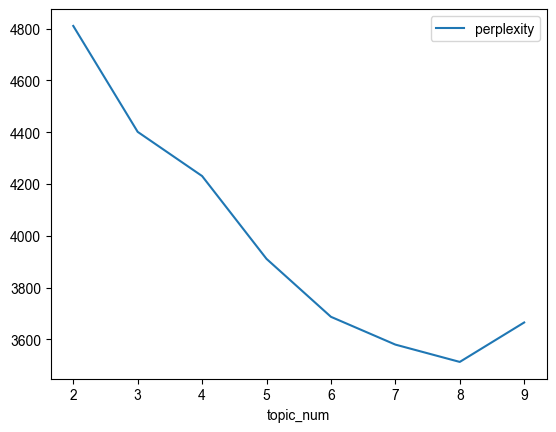

In [184]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

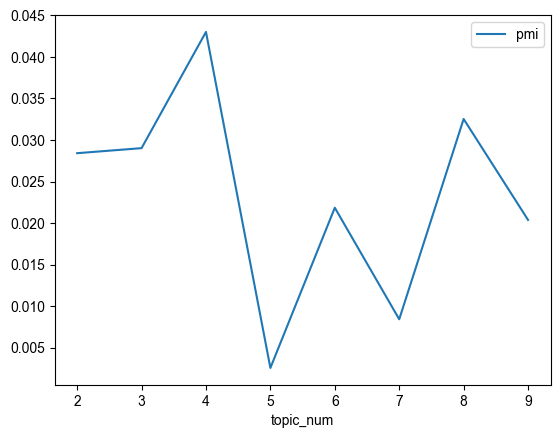

In [185]:
result.plot.line(x='topic_num', y='pmi')

透過指標找到最佳的主題數（topics_num = 8）

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [186]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 8,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2024-05-05 16:57:25,582 : INFO : using symmetric alpha at 0.125
2024-05-05 16:57:25,586 : INFO : using symmetric eta at 0.125
2024-05-05 16:57:25,594 : INFO : using serial LDA version on this node
2024-05-05 16:57:25,636 : INFO : running online (multi-pass) LDA training, 8 topics, 5 passes over the supplied corpus of 6458 documents, updating model once every 2000 documents, evaluating perplexity every 6458 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 16:57:25,651 : INFO : PROGRESS: pass 0, at document #2000/6458
2024-05-05 16:57:27,802 : INFO : merging changes from 2000 documents into a model of 6458 documents
2024-05-05 16:57:27,821 : INFO : topic #7 (0.125): 0.008*"今天" + 0.006*"表示" + 0.006*"以色列" + 0.005*"中國" + 0.004*"美國" + 0.004*"俄羅斯" + 0.004*"大谷翔平" + 0.004*"加薩" + 0.003*"報導" + 0.003*"日本"
2024-05-05 16:57:27,825 : INFO : topic #4 (0.125): 0.007*"美國" + 0.006*"表示" + 0.006*"今天" + 0.005*"水原" + 0.004*"台灣" + 0.004*"球員" + 0.004*"以色列" + 0.003*"去年" + 0.003*"今年" 

In [187]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.204084  0.040867       1        1  23.917965
5      0.036322  0.154651       2        1  16.635740
2     -0.105760 -0.237465       3        1  14.292549
7     -0.172603  0.119103       4        1  11.858332
0     -0.161701  0.090652       5        1  11.202105
1      0.167588  0.072876       6        1  10.880971
6     -0.147098 -0.082920       7        1   7.132534
3      0.179168 -0.157764       8        1   4.079803, topic_info=      Term         Freq        Total Category  logprob  loglift
5853    中國  9444.000000  9444.000000  Default  30.0000  30.0000
13547   晶片  1391.000000  1391.000000  Default  29.0000  29.0000
8983    小米  1806.000000  1806.000000  Default  28.0000  28.0000
2829    市場  5773.000000  5773.000000  Default  27.0000  27.0000
505     億元  3596.000000  3596.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
5835    產品   242.392769  1502.255993   Topic8  -5.2810   1.3750
328     公司   257.100270  4619.231326   Topic8  -5.2221   0.3106
1161    提供   225.232019  1583.695851   Topic8  -5.3544   1.2487
7827    科技   211.671315  1564.350660   Topic8  -5.4165   1.1989
225     表示   213.783486  7922.881877   Topic8  -5.4066  -0.4134

[618 rows x 6 columns], token_table=       Topic      Freq Term
term                       
756        2  0.024071   一名
756        3  0.063787   一名
756        4  0.103503   一名
756        5  0.471782   一名
756        6  0.010832   一名
...      ...       ...  ...
15721      8  0.994504   黃仁
2493       1  0.924439   黃金
2493       2  0.008746   黃金
2493       5  0.060347   黃金
2493       7  0.006122   黃金

[1657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 3, 8, 1, 2, 7, 4])

可以看到(1,6)和(4,5)很相近，試試看跑4個主題，可以看到主題被完美個切分開

In [188]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-05-05 16:58:28,908 : INFO : using symmetric alpha at 0.25


2024-05-05 16:58:28,925 : INFO : using symmetric eta at 0.25
2024-05-05 16:58:28,961 : INFO : using serial LDA version on this node
2024-05-05 16:58:29,010 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 6458 documents, updating model once every 2000 documents, evaluating perplexity every 6458 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 16:58:29,032 : INFO : PROGRESS: pass 0, at document #2000/6458
2024-05-05 16:58:31,992 : INFO : merging changes from 2000 documents into a model of 6458 documents
2024-05-05 16:58:31,999 : INFO : topic #0 (0.250): 0.009*"俄羅斯" + 0.008*"烏克蘭" + 0.007*"今天" + 0.007*"表示" + 0.006*"美國" + 0.004*"報導" + 0.004*"以色列" + 0.003*"今年" + 0.003*"中國" + 0.003*"去年"
2024-05-05 16:58:32,003 : INFO : topic #1 (0.250): 0.009*"表示" + 0.008*"今天" + 0.007*"以色列" + 0.004*"美國" + 0.004*"報導" + 0.004*"日本" + 0.003*"台灣" + 0.003*"政府" + 0.003*"比賽" + 0.003*"加薩"
2024-05-05 16:58:32,021 : INFO : topic #2 (0.250): 0.

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.192104  0.154674       1        1  30.437584
1      0.030325 -0.171508       2        1  26.884757
3      0.250355  0.107413       3        1  21.432371
0     -0.088577 -0.090579       4        1  21.245287, topic_info=      Term         Freq        Total Category  logprob  loglift
5853    中國  9322.000000  9322.000000  Default  30.0000  30.0000
505     億元  4314.000000  4314.000000  Default  29.0000  29.0000
16352   台股  2079.000000  2079.000000  Default  28.0000  28.0000
6743    香港  2454.000000  2454.000000  Default  27.0000  27.0000
5860    大陸  5342.000000  5342.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
10098   北京   589.514181  1401.802768   Topic4  -6.0423   0.6828
505     億元   801.056787  4314.337905   Topic4  -5.7357  -0.1347
5860    大陸   839.315456  5342.841815   Topic4  -5.6891  -0.3019
2829    市場   730.531301  5410.231523   Topic4  -5.8279  -0.4532
295     認為   649.459561  2220.300519   Topic4  -5.9455   0.3198

[350 rows x 6 columns], token_table=       Topic      Freq Term
term                       
756        1  0.826776   一名
756        2  0.002844   一名
756        3  0.002844   一名
756        4  0.167820   一名
0          1  0.996814   一平
...      ...       ...  ...
15887      2  0.005219   鴻海
15887      3  0.993262   鴻海
2493       2  0.007558   黃金
2493       3  0.108325   黃金
2493       4  0.884232   黃金

[746 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

替換成主題數後，可以發現文章有明顯的分群，被分類成四個主題且各自有唯一性，可以更好的觀察文本中的資訊！

* 主題1：涉及中國的商業環境，包括政策影響和公司動態
* 主題2：聚焦於半導體行業，尤其是中美之間在晶片技術和市場上的競爭
* 主題3：與股市投資、財經分析和金融交易密切相關的術語
* 主題4：與中國及香港的科技產業發展、經濟政策有關。涉及的公司（如小米、蘋果、華為）及產業（如汽車產業）

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [189]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.8` 可正常執行

In [190]:
import guidedlda

In [191]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一平', '一番', '一語', '不發', '今年', '債務', '償還', '出現', '加盟', '動用')

In [192]:
word2id = dictionary.token2id

定義了以下5個主題

In [196]:
seed_topic_list = [
    ["大谷翔平", "樂天", "大聯盟", "先發", "道奇"],
    ["台股", "投資", "債券", "股市", "基金"],
    ["台積電", "半導體", "科技", "技術", "晶片"],
    ["中國", "兩岸", "南海", "政府", "外交"],
    ["全球", "美國", "烏克蘭", "拜登", "日本"]
]

In [197]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [198]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [199]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-05 17:08:14,739 : INFO : n_documents: 6458
2024-05-05 17:08:14,740 : INFO : vocab_size: 18833
2024-05-05 17:08:14,742 : INFO : n_words: 1167851
2024-05-05 17:08:14,748 : INFO : n_topics: 6
2024-05-05 17:08:14,758 : INFO : n_iter: 100
2024-05-05 17:08:40,103 : INFO : <0> log likelihood: -12595082
2024-05-05 17:08:41,591 : INFO : <20> log likelihood: -9824824
2024-05-05 17:08:42,772 : INFO : <40> log likelihood: -9768006
2024-05-05 17:08:43,783 : INFO : <60> log likelihood: -9752811
2024-05-05 17:08:45,226 : INFO : <80> log likelihood: -9745303
2024-05-05 17:08:46,243 : INFO : <99> log likelihood: -9740023


In [200]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 今天 比賽 大谷 水原 球員 球隊 今年 大谷翔平 投手 先發
Topic 1: 市場 指數 投資 台股 投資人 美國 今年 降息 上漲 股息
Topic 2: 公司 今年 市場 去年 營收 億元 產品 成長 表示 汽車
Topic 3: 中國 大陸 國家 美國 發展 表示 香港 經濟 台灣 關係
Topic 4: 美國 以色列 表示 報導 俄羅斯 今天 政府 烏克蘭 川普 總統
Topic 5: 報導 表示 媒體 工作 調查 公司 日本 發現 網友 問題


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.119192 -0.004013       1        1  19.196895
1     -0.250566 -0.011206       2        1  17.533148
3      0.061279  0.150436       3        1  17.154575
2     -0.214530  0.057185       4        1  17.098789
4      0.203211  0.134518       5        1  15.573979
0      0.081414 -0.326919       6        1  13.442614, topic_info=     Term         Freq        Total Category  logprob  loglift
5853   中國  7763.000000  7763.000000  Default  30.0000  30.0000
9270  以色列  2238.000000  2238.000000  Default  29.0000  29.0000
2829   市場  4647.000000  4647.000000  Default  28.0000  28.0000
5860   大陸  3376.000000  3376.000000  Default  27.0000  27.0000
2299   指數  2134.000000  2134.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
15     去年   608.298496  3796.297278   Topic6  -5.5533   0.1756
2143   台灣   589.320693  3836.370440   Topic6  -5.5850   0.1334
225    表示   564.349901  8060.355616   Topic6  -5.6283  -0.6523
748    紀錄   414.525145   764.253476   Topic6  -5.9368   1.3950
1404   最後   420.518135   967.066911   Topic6  -5.9224   1.1740

[444 rows x 6 columns], token_table=       Topic      Freq Term
term                       
756        1  0.706342   一名
756        5  0.253804   一名
756        6  0.039507   一名
0          6  0.998806   一平
6189       1  1.000348   丈夫
...      ...       ...  ...
6743       3  0.762413   香港
6743       4  0.008890   香港
6743       6  0.000523   香港
17282      2  0.999579   高息
15721      4  1.000720   黃仁

[877 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 4, 3, 5, 1])

## 7. 主題分佈的應用，搭配其他文章資訊

In [208]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [209]:
topics_doc[100]

[(0, 0.09675909), (1, 0.010442031), (2, 0.6594757), (3, 0.2333232)]

將文本轉換成主題的分佈

In [210]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.02398871, 0.        , 0.97186166, 0.        ],
       [0.        , 0.        , 0.99643451, 0.        ],
       [0.        , 0.        , 0.99505246, 0.        ],
       ...,
       [0.12101945, 0.        , 0.87703454, 0.        ],
       [0.        , 0.        , 0.99460095, 0.        ],
       [0.        , 0.        , 0.99625582, 0.        ]])

In [211]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [212]:
udn['topic_label'].value_counts()

topic_label
3    2015
4    1614
2    1583
1    1246
Name: count, dtype: int64

將每篇文章分類到特定的主題(topic_label)上面，<br>從以下文章可以看出主題三的主題「美國職棒大聯盟」有關

In [220]:
# 篩選主題標籤為1的文章
topic_1_data = udn[udn['topic_label'] == 1]

# 查看文章內容
for index, row in topic_1_data.iterrows():
    print("文章內容:", row['content'])
    print("===============================================")

文章內容: 樂天桃猿隊日前爆發樂天女孩私接活動風波前領隊浦韋青樂天女孩前經紀人陳元凱遭到告發今天桃園地檢署發布新聞稿表示將起訴陳姓經理人聲請沒收不法所得餘萬元桃園地檢署表示經過傳訊相關被告證人分析被告手機紀錄及調取相關金流後發現被告陳姓經理違反樂天公司之工作規則藉由擔任樂天女孩經紀人以自己經營之公司向廠商接洽安排樂天女孩演藝活動收取費用樂天桃猿隊日前爆發樂天女孩私接活動風波樂天女孩前經紀人陳元凱被起訴圖翻攝自臉書粉專新聞稿中也指出為避免遭樂天公司發覺私接活動而於收取廠商演藝活動費用後陳姓經理與他人合謀另開立低報費用之不實發票予樂天公司從中賺取不法利益新台幣萬元另發覺樂天公司浦姓副總經理為達年月日棒球隊門票銷售量與他人謀議製作購買萬元門票之不實銷售記錄製造門票銷售之假象全案經檢察官調查詳盡於今日偵查終結認被告陳元凱浦韋青等人分別涉犯刑法第條第項背信等罪嫌並聲請沒收被告等人不法所得萬元
文章內容: 中國足壇反腐系列案近日宣判陸媒指出與反腐案有關的俱樂部只有廣州恆大等家曝光至少逾家判決書披露涉行賄打假球的俱樂部都未公開中國足協應予以懲戒足球報日前發表文章表示曾在中國足協中超公司擔任要職的陳戌源于洪臣陳永亮等人近日被判刑而相關判決書披露的行賄打假球俱樂部至少家以上被公開點名的除了廣州恆大其餘家已解散文章說上一輪足壇反賭掃黑案宣判時涉案家俱樂部全被曝光並公開處罰這次足壇反腐案涉案金額巨大但公開的庭審細節未列出涉案俱樂部名單和詳細行賄金額文章建議中國足協懲戒所有行賄打假球的俱樂部文章還披露公安紀檢監察部門調查足協期間有部分足協人員主動交代或是在被查出問題後退贓因此目前繼續留在足協工作甚至仍在原來職位這明顯是個大隱患未來年中國足協還可能出現陳永亮這樣的不倒翁湖北多地法院月日對起足球領域腐敗案進行宣判包括前中國足協主席陳戌源被判無期徒刑曾任中國足球協會副主席的中國田協前主席于洪臣被判有期徒刑年此外前中國足球協會常務副秘書長兼國家隊管理部部長陳永亮前中超聯賽有限責任公司總經理董錚以及曾任武漢市足球管理中心競賽部部長的武漢全民健身中心副主任劉磊分別被判有期徒刑年年及年個月
文章內容: 烏克蘭情報部門一位消息人士今天告訴路透社俄烏戰爭迄今烏克蘭安全局出動的遠程攻擊無人機已成功擊中座俄羅斯煉油廠俄羅斯南部克拉斯諾達州的官員表示烏克蘭無人機於夜間襲擊了位於該州首府以北公里的斯拉揚斯克煉油廠前

In [213]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,曾經是形影不離的戰友大谷翔平與水原一平如今因金錢關係成為陌生人大谷翔平的個人社群也解除對水原...,https://udn.com/news/story/11247/7845714,運動,2024/3/21 9:56,"[曾經, 形影不離, 戰友, 大谷翔平, 水原, 一平, 金錢, 關係, 成為, 陌生人, ...",3
1,日本棒球明星大谷翔平的翻譯水原一平傳出涉嫌竊取數百萬美元非法簽賭已遭洛杉磯道奇解雇大谷轉戰美...,https://udn.com/news/story/11247/7845808,運動,2024/3/21 10:28,"[日本, 棒球, 明星, 大谷翔平, 翻譯, 水原, 一平, 傳出, 涉嫌, 竊取, 數百,...",3
2,美國職棒大聯盟球星大谷翔平的隨行翻譯水原一平因涉嫌竊取大谷至少萬美元進行非法賭博遭到道奇隊開...,https://udn.com/news/story/11247/7845856,運動,2024/3/21 10:36,"[美國, 職棒, 大聯盟, 球星, 大谷翔平, 隨行, 翻譯, 水原, 一平, 涉嫌, 竊取...",3
3,道奇教士隊在南韓首爾進行新球季第場比賽前大谷翔平的翻譯水原一平遭球團開除一位美職賽事資深球評...,https://udn.com/news/story/11247/7845919,運動,2024/3/21 10:56,"[道奇, 教士隊, 南韓, 首爾, 進行, 新球季, 第場, 比賽, 大谷翔平, 翻譯, 水...",3
4,美國職棒大聯盟明星大谷翔平的翻譯水原一平傳出涉賭遭球隊解僱水原美國時間日接受採訪說大谷替他還...,https://udn.com/news/story/11247/7846177,運動,2024/3/21 12:13,"[美國, 職棒, 大聯盟, 明星, 大谷翔平, 翻譯, 水原, 一平, 傳出, 涉賭, 球隊...",3


再利用時間去分隔，可以得出不同時間段的主題比例

In [214]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [215]:
udn['artDate'].dt.date

0       2024-03-21
1       2024-03-21
2       2024-03-21
3       2024-03-21
4       2024-03-21
           ...    
6453    2024-04-03
6454    2024-04-03
6455    2024-04-03
6456    2024-04-04
6457    2024-04-04
Name: artDate, Length: 6458, dtype: object

In [216]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-03-17  3              0.423664
            1              0.217557
            4              0.206107
            2              0.152672
2024-03-18  3              0.282116
                             ...   
2024-04-03  1              0.166259
2024-04-04  2              0.482759
            3              0.264368
            1              0.160920
            4              0.091954
Name: proportion, Length: 76, dtype: float64

In [217]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4
artDate,,,,
2024-03-17,0.217557,0.152672,0.423664,0.206107
2024-03-18,0.214106,0.246851,0.282116,0.256927
2024-03-19,0.183374,0.288509,0.293399,0.234719
2024-03-20,0.170068,0.281179,0.276644,0.272109
2024-03-21,0.174208,0.257919,0.350679,0.217195


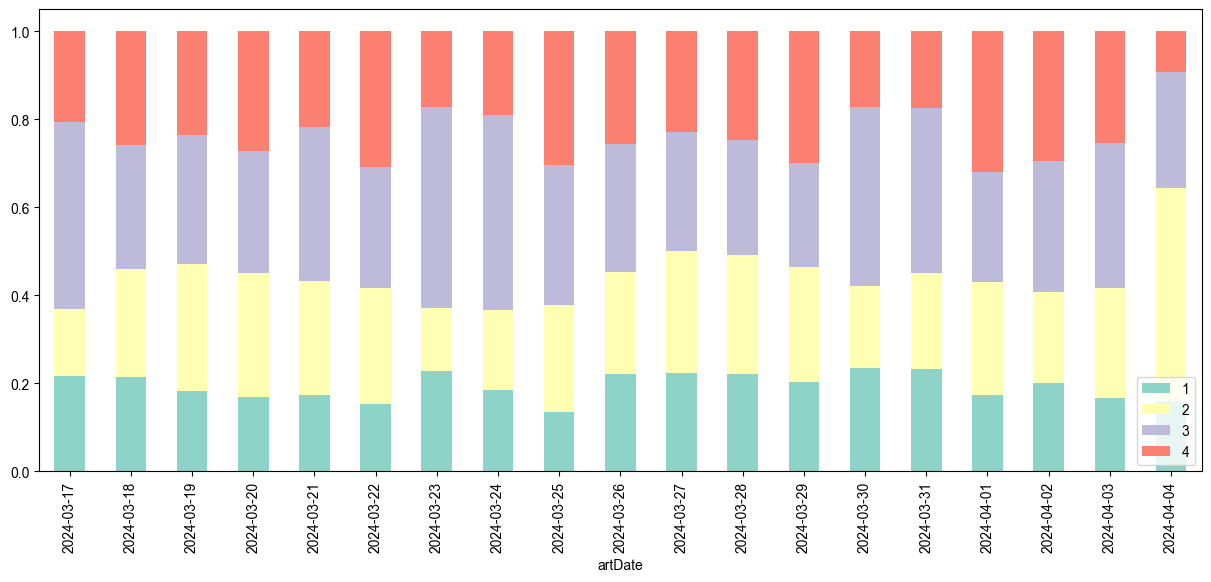

In [218]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題3（美國職棒）在 如3月17日和3月23日，<br>
主題3被討論的比例高於其他主題，細看文章內容圍繞在「大谷翔平」及其翻譯「水原一平」之間的事件，<br>
特別是涉及金錢和非法活動的問題，其中水原一平涉嫌竊取資金並進行非法賭博，最終被道奇隊開除。